<a href="https://colab.research.google.com/github/Gym28/DespligueAlgoritmosFInal/blob/main/Final_YuriM_Detecci%C3%B3n_Trolls_en_Twitch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica Final: detección de mensajes troll en chat de Twitch en tiempo real

Durante este último año la plataforma de vídeo en streaming Twitch ha cogido mucha popularidad debido a la situación que hemos vivido debido al COVID-19. Por esto, mucha gente de todas las edades ha empezado a consumir esta plataforma de manera diaria.

Como consecuencia, no sólo han aumentado las personas que ven contenido en Twitch, sino también el número de los denominados *trolls*, gente que pone comentarios ofensivos en los chat de los streamers.

En esta práctica se desarrollará un sistema autónomo basado en IA y desplegado en GCP que detectará en tiempo real si los mensajes que se envían a un canal de Twitch son de un *troll* o no. La práctica constará de tres partes principales que serán evaluadas en la corrección:
1. Entrenamiento e inferencia en Batch de un modelo usando Dataflow y AI Platform. **(3.5 puntos)**.
2. Despliegue e inferencia online en microservicio con el modelo. **(3.5 puntos)**.
3. Inferencia en streaming de un canal de Twitch con el microservicio anterior. **(3 puntos)**.

# Configuración de nuestro proyecto en GCP


In [1]:
PROJECT_ID = "practica-final-355911 " #@param {type:"string"}
! gcloud config set project $PROJECT_ID

Updated property [core/project].


In [2]:
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

# If you are running this notebook locally, replace the string below with the
# path to your service account key and run this cell to authenticate your GCP
# account.
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''


In [3]:
BUCKET_NAME = "twitchsentiment" #@param {type:"string"}
REGION = "europe-west1" #@param {type:"string"}

In [4]:
! gsutil mb -l $REGION gs://$BUCKET_NAME

Creating gs://twitchsentiment/...
ServiceException: 409 A Cloud Storage bucket named 'twitchsentiment' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [4]:
! gsutil ls -al gs://$BUCKET_NAME  #EL SENTIMENT-BATCH FUE UNA PRUEBA PORQUE NO SUBIAN NO SUBIERON LOS OTROS ARCHIVOS MENSAJE ENVIADO POR SLACK

   2756023  2022-07-10T16:50:51Z  gs://twitchsentiment/data.json#1657471851873830  metageneration=1
TOTAL: 1 objects, 2756023 bytes (2.63 MiB)


# Entrenamiento e inferencia en Batch

Para esta primera parte se va a utilizar [Tweets Dataset for Detection of Cyber-Trolls](https://www.kaggle.com/dataturks/dataset-for-detection-of-cybertrolls). El objetivo es desarrollar un clasificador binario para detectar si el mensaje recibido es troll (1) o no (0). **Las métricas obtenidas del entrenamiento y la inferencia no se tendrán en cuenta para la evaluación de la práctica, la importancia está en la arquitectura de la solución**.

A continuación os dejo un diagrama con la arquitectura que se va a desarrollar:

![batch_diagram](https://drive.google.com/uc?export=view&id=1h1BkIunyKSkJYFRbXKNWpHOZ_rDUyGAT)

A continuación, se van a subir los datos de entrenamiento al bucket del proyecto que se haya creado. **Importante:** crea el bucket en una única región para evitar problemas más adelante.

In [7]:
# Upload data to your bucket
! wget https://storage.googleapis.com/twitch-practice-keepcoding/data.json -O - | gsutil cp - gs://$BUCKET_NAME/data.json

--2022-07-10 16:50:49--  https://storage.googleapis.com/twitch-practice-keepcoding/data.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 142.251.31.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2756023 (2.6M) [application/json]
Saving to: ‘STDOUT’

-                     0%[                    ]       0  --.-KB/s               Copying from <STDIN>...
-                   100%[===================>]   2.63M  1.30MB/s    in 2.0s    

2022-07-10 16:50:51 (1.30 MB/s) - written to stdout [2756023/2756023]

/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              


Ahora se crea el directorio dónde vas a desarrollar esta primera parte de la práctica.

In [8]:
%mkdir /content/batch

Se establece el directorio de trabajo que hemos creado.

In [7]:
import os

# Set the working directory to the sample code directory
%cd /content/batch

WORK_DIR = os.getcwd()

/content/batch


Ahora se descargarán los datos en el workspace de Colab para trabajar en local.

In [10]:
! wget https://storage.googleapis.com/twitch-practice-keepcoding/data.json

--2022-07-10 16:51:04--  https://storage.googleapis.com/twitch-practice-keepcoding/data.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 108.177.119.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2756023 (2.6M) [application/json]
Saving to: ‘data.json’

data.json           100%[===================>]   2.63M  --.-KB/s    in 0.01s   

2022-07-10 16:51:04 (204 MB/s) - ‘data.json’ saved [2756023/2756023]



Se establecen las dependencias que se usarán en la práctica. Se pueden añadir y quitar las dependencias que no se usen o viceversa.

In [5]:
%%writefile requirements.txt

apache-beam[gcp]==2.24.0
tensorflow
gensim==3.6.0
fsspec==0.8.4
gcsfs==0.7.1
numpy==1.20.0

Writing requirements.txt


In [12]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 3.9 MB/s 
     |████████████████████████████████| 91 kB 9.7 MB/s 
     |████████████████████████████████| 15.3 MB 58.3 MB/s 
     |████████████████████████████████| 1.1 MB 62.6 MB/s 
     |████████████████████████████████| 63.8 MB 1.1 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 829 kB 53.4 MB/s 
     |████████████████████████████████| 1.4 MB 68.3 MB/s 
     |████████████████████████████████| 77 kB 4.7 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 508 kB 72.3 MB/s 
     |████████████████████████████████| 151 kB 74.6 MB/s 
     |████████████████████████████████| 255 kB 71.9 MB/s 
     |████████████████████████████████| 173 kB 85.7 MB/s 
     |████████████████████████████████| 83 kB 2.1 MB/s 
     |████████████████████████████████| 4

In [8]:
import pandas as pd
import json
data = 'data.json'
print(os.path.isfile(data))
df = pd.read_json(data , lines=True)
df.head()

True


,content,annotation,extras
0,Get fucking real dude.,"{'notes': '', 'label': ['1']}",NaN
1,She is as dirty as they come and that crook ...,"{'notes': '', 'label': ['1']}",NaN
2,why did you fuck it up. I could do it all day...,"{'notes': '', 'label': ['1']}",NaN
3,Dude they dont finish enclosing the fucking s...,"{'notes': '', 'label': ['1']}",NaN
4,WTF are you talking about Men? No men thats n...,"{'notes': '', 'label': ['1']}",NaN


In [9]:
cols=["content","annotation"]
for name in cols:
      print(name, ";")
      print(df[name].value_counts(), "\n")

content ;
#NAME?                                                                                                                    38
  nope                                                                                                                    21
  yes.                                                                                                                    20
  yes                                                                                                                     20
I hate you.                                                                                                               12
                                                                                                                          ..
It's sucks..lol  cause any other time I'd be fine with 1 meal  but because I cant have none  it's driving me nuts..lol     1
Nice robot post!... LOL&gt; I hate those cheesy responses too.                                                     

In [10]:
round(df.isnull().mean()*100,2).sort_values(ascending=False)

extras        100.0
content         0.0
annotation      0.0
dtype: float64

##**Entreglable (0.5 puntos)**

Desarrollar un pipeline de preprocesamiento utilizando Apache Beam para generar datos de train, eval y test para los datos proporcionados anteriormente. Requisitos:

- Proporcionar dos modos de ejecución: `train` y `test`
- Soportar ejecuciones en local con `DirectRunner` y ejecuciones en Dataflow usando `DataFlowRunner`.

In [11]:
%%writefile preprocess.py

# pytype: skip-file


from __future__ import absolute_import

import argparse
import logging
import re
import os
import csv
import random

from past.builtins import unicode

import apache_beam as beam
from apache_beam.io import ReadFromText
from apache_beam.io import WriteToText
from apache_beam.coders.coders import Coder
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions, DirectOptions

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import json

# CLEANING
STOP_WORDS = stopwords.words("english")
STEMMER = SnowballStemmer("english")
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

class ExtractColumnsDoFn(beam.DoFn):
   
   
    def process(self, element):
        # space removal
        element_split = json.loads(element)
        # text, sentiment
        yield element_split['content'], element_split['annotation']['label'][0]
        
class PreprocessColumnsTrainFn(beam.DoFn):
   
   
    def process_sentiment(self, sentiment):
        sentiment = int(sentiment)
        if sentiment == 1:
            return "NON TROLL"
        else:
            return "TROLL"   

    def process_text(self, text):
        # Remove link,user and special characters
        stem = False
        text = re.sub(TEXT_CLEANING_RE, " ", str(text).lower()).strip()
        tokens = []
        for token in text.split():
            if token not in STOP_WORDS:
                if stem:
                    tokens.append(STEMMER.stem(token))
                else:
                    tokens.append(token)
        return " ".join(tokens)

    def process(self, element):
        processed_text = self.process_text(element[0])
        processed_sentiment = self.process_sentiment(element[1])
        yield f"{processed_text}, {processed_sentiment}"


class CustomCoder(Coder):
    """A custom coder used for reading and writing strings"""

    def __init__(self, encoding: str):
        # latin-1
        # iso-8859-1
        self.enconding = encoding

    def encode(self, value):
        return value.encode(self.enconding)

    def decode(self, value):
        return value.decode(self.enconding)

    def is_deterministic(self):
        return True


def run(argv=None, save_main_session=True):

    """Main entry point; defines and runs the wordcount pipeline."""

    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--work-dir", dest="work_dir", required=True, help="Working directory",
    )

    parser.add_argument(
        "--input", dest="input", required=True, help="Input dataset in work dir",
    )
    parser.add_argument(
        "--output",
        dest="output",
        required=True,
        help="Output path to store transformed data in work dir",
    )
    parser.add_argument(
        "--mode",
        dest="mode",
        required=True,
        choices=["train", "test"],
        help="Type of output to store transformed data",
    )

    known_args, pipeline_args = parser.parse_known_args(argv)

    # We use the save_main_session option because one or more DoFn's in this
    # workflow rely on global context (e.g., a module imported at module level).
    pipeline_options = PipelineOptions(pipeline_args)
    pipeline_options.view_as(SetupOptions).save_main_session = save_main_session
    pipeline_options.view_as(DirectOptions).direct_num_workers = 0

    # The pipeline will be run on exiting the with block.
    with beam.Pipeline(options=pipeline_options) as p:

        # Read the text file[pattern] into a PCollection.
        raw_data = p | "ReadTwitterData" >> ReadFromText(
            known_args.input, coder=CustomCoder("latin-1")
        )

        if known_args.mode == "train":

            transformed_data = (
                raw_data
                | "ExtractColumns" >> beam.ParDo(ExtractColumnsDoFn())
                | "Preprocess" >> beam.ParDo(PreprocessColumnsTrainFn())
            )

            eval_percent = 20
            assert 0 < eval_percent < 100, "eval_percent must in the range (0-100)"
            train_dataset, eval_dataset = (
                transformed_data
                | "Split dataset"
                >> beam.Partition(
                    lambda elem, _: int(random.uniform(0, 100) < eval_percent), 2
                )
            )

            train_dataset | "TrainWriteToCSV" >> WriteToText(
                os.path.join(known_args.output, "train", "part")
            )
            eval_dataset | "EvalWriteToCSV" >> WriteToText(
                os.path.join(known_args.output, "eval", "part")
            )

        else:
            transformed_data = (
                raw_data
                | "ExtractColumns" >> beam.ParDo(ExtractColumnsDoFn())
                | "Preprocess" >> beam.Map(lambda x: f'"{x[0]}"')
            )

            transformed_data | "TestWriteToCSV" >> WriteToText(
                os.path.join(known_args.output, "test", "part")
            )


if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    run()

Writing preprocess.py


Se proporciona un fichero `setup.py` necesario para ejecutar en DataFlow. Modificar la variable `REQUIRED_PACKAGES` con las dependencias que se hayan usado en el `requirements.txt`

In [12]:
%%writefile setup.py

import setuptools

REQUIRED_PACKAGES = [
  "apache-beam[gcp]==2.24.0",
  "tensorflow==2.8.0",
  "gensim==3.6.0",
  "fsspec==0.8.4",
  "gcsfs==0.7.1",
  "numpy==1.20.0",
  "keras==2.8.0",
]

setuptools.setup(
    name="twitchstreaming",
    version="0.0.1",
    install_requires=REQUIRED_PACKAGES,
    packages=setuptools.find_packages(),
    include_package_data=True,
    description="Troll detection",
)


Writing setup.py


### Validación preprocess train en local (0.25 puntos)

Con el comando mostrado a continuación se valida la correcta generación de los datos de entrenamiento y validación en local.

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
! python3 preprocess.py \
  --work-dir $WORK_DIR \
  --runner DirectRunner \
  --input $WORK_DIR/data.json \
  --output $WORK_DIR/transformed_data \
  --mode train

INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function annotate_downstream_side_inputs at 0x7fd4926bcdd0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function fix_side_input_pcoll_coders at 0x7fd4926bcef0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function lift_combiners at 0x7fd4926bcf80> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_sdf at 0x7fd4926bd050> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_gbk at 0x7fd4926bd0e0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function sink_flattens at 0x7fd4926bd200> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:===============

### Validación preprocess test en local (0.25 puntos)

Con el comando mostrado a continuación se valida la correcta generación de los datos de test en local.

In [15]:
! python3 preprocess.py \
  --work-dir $WORK_DIR \
  --runner DirectRunner \
  --input $WORK_DIR/data.json \
  --output $WORK_DIR/transformed_data \
  --mode test

INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function annotate_downstream_side_inputs at 0x7fdcfd584cb0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function fix_side_input_pcoll_coders at 0x7fdcfd584dd0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function lift_combiners at 0x7fdcfd584e60> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_sdf at 0x7fdcfd584ef0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_gbk at 0x7fdcfd584f80> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function sink_flattens at 0x7fdcfd5850e0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:===============

## Entregable 2 (1.25 puntos)

Desarrollar una tarea de entrenamiento para los datos preprocesados. Requisitos:

- Soportar ejecuciones en local usando el SDK de AI-Platform y ejecuciones en GCP con el mismo código.

Se crea el directorio donde se dejará este entregable.

In [16]:
%mkdir /content/batch/trainer

In [17]:
%%writefile trainer/__init__.py

version = "0.1.0"

Writing trainer/__init__.py


In [18]:
%%writefile trainer/task.py

from __future__ import absolute_import

import argparse
import multiprocessing as mp
import logging
import tempfile
import os

import pickle
import gensim
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Embedding,
    LSTM,
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder


# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
# 32
W2V_EPOCH = 5
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300

# SENTIMENT
POSITIVE = "TROLL"
NEGATIVE = "NON_TROLL"



# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


def generate_word2vec(train_df):
    documents = [_text.split() for _text in train_df.text.values]
    w2v_model = gensim.models.word2vec.Word2Vec(
        size=W2V_SIZE,
        window=W2V_WINDOW,
        min_count=W2V_MIN_COUNT,
        workers=mp.cpu_count(),
    )
    w2v_model.build_vocab(documents)

    words = w2v_model.wv.vocab.keys()
    vocab_size = len(words)
    logging.info(f"Vocab size: {vocab_size}")
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

    return w2v_model


def generate_tokenizer(train_df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df.text)
    vocab_size = len(tokenizer.word_index) + 1
    logging.info(f"Total words: {vocab_size}")
    return tokenizer, vocab_size


def generate_label_encoder(train_df):
    encoder = LabelEncoder()
    encoder.fit(train_df.sentiment.tolist())
    return encoder


def generate_embedding(word2vec_model, vocab_size, tokenizer):
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return Embedding(
        vocab_size,
        W2V_SIZE,
        weights=[embedding_matrix],
        input_length=SEQUENCE_LENGTH,
        trainable=False,
    )


def train_and_evaluate(
    work_dir, train_df, eval_df, batch_size=1024, epochs=8, steps=1000
):

    """
    Trains and evaluates the estimator given.
    The input functions are generated by the preprocessing function.
    """

    model_dir = os.path.join(work_dir, "model")
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)
    tf.io.gfile.mkdir(model_dir)

    # Specify where to store our model
    run_config = tf.estimator.RunConfig()
    run_config = run_config.replace(model_dir=model_dir)

    # This will give us a more granular visualization of the training
    run_config = run_config.replace(save_summary_steps=10)

    # Create Word2vec of training data
    logging.info("---- Generating word2vec model ----")
    word2vec_model = generate_word2vec(train_df)

    # Tokenize training data
    logging.info("---- Generating tokenizer ----")
    tokenizer, vocab_size = generate_tokenizer(train_df)

    logging.info("---- Tokenizing train data ----")
    x_train = pad_sequences(
        tokenizer.texts_to_sequences(train_df.text), maxlen=SEQUENCE_LENGTH
    )
    logging.info("---- Tokenizing eval data ----")
    x_eval = pad_sequences(
        tokenizer.texts_to_sequences(eval_df.text), maxlen=SEQUENCE_LENGTH
    )

    # Label Encoder
    logging.info("---- Generating label encoder ----")
    label_encoder = generate_label_encoder(train_df)

    logging.info("---- Encoding train target ----")
    y_train = label_encoder.transform(train_df.sentiment.tolist())
    logging.info("---- Encoding eval target ----")
    y_eval = label_encoder.transform(eval_df.sentiment.tolist())

    y_train = y_train.reshape(-1, 1)
    y_eval = y_eval.reshape(-1, 1)

    # Create Embedding Layer
    logging.info("---- Generating embedding layer ----")
    embedding_layer = generate_embedding(word2vec_model, vocab_size, tokenizer)

    logging.info("---- Generating Sequential model ----")
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation="sigmoid"))

    model.summary()

    logging.info("---- Adding loss function to model ----")
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    logging.info("---- Adding callbacks to model ----")
    callbacks = [
        ReduceLROnPlateau(monitor="val_loss", patience=5, cooldown=0),
        EarlyStopping(monitor="val_accuracy", min_delta=1e-4, patience=5),
    ]

    logging.info("---- Training model ----")
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        steps_per_epoch=steps,
        epochs=epochs,
        validation_split=0.1,
        verbose=1,
        callbacks=callbacks,
    )

    logging.info("---- Evaluating model ----")
    score = model.evaluate(x_eval, y_eval, batch_size=batch_size)
    logging.info(f"ACCURACY: {score[1]}")
    logging.info(f"LOSS: {score[0]}")

    logging.info("---- Saving models ----")
    pickle.dump(
        tokenizer,
        tf.io.gfile.GFile(os.path.join(model_dir, TOKENIZER_MODEL), mode="wb"),
        protocol=0,
    )
    with tempfile.NamedTemporaryFile(suffix=".h5") as local_file:
        with tf.io.gfile.GFile(
            os.path.join(model_dir, KERAS_MODEL), mode="wb"
        ) as gcs_file:
            model.save(local_file.name)
            gcs_file.write(local_file.read())

    # word2vec_model.save(os.path.join(model_dir, WORD2VEC_MODEL))

    # pickle.dump(
    #     label_encoder, open(os.path.join(model_dir, ENCODER_MODEL), "wb"), protocol=0
    # )


if __name__ == "__main__":

    """Main function called by AI Platform."""

    logging.getLogger().setLevel(logging.INFO)

    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )

    parser.add_argument(
        "--job-dir",
        help="Directory for staging trainer files. "
        "This can be a Google Cloud Storage path.",
    )

    parser.add_argument(
        "--work-dir",
        required=True,
        help="Directory for staging and working files. "
        "This can be a Google Cloud Storage path.",
    )

    parser.add_argument(
        "--batch-size",
        type=int,
        default=1024,
        help="Batch size for training and evaluation.",
    )

    parser.add_argument(
        "--epochs", type=int, default=8, help="Number of epochs to train the model",
    )

    parser.add_argument(
        "--steps",
        type=int,
        default=1000,
        help="Number of steps per epoch to train the model",
    )

    args = parser.parse_args()

    train_data_files = tf.io.gfile.glob(
        os.path.join(args.work_dir, "transformed_data/train/part-*")
    )
    eval_data_files = tf.io.gfile.glob(
        os.path.join(args.work_dir, "transformed_data/eval/part-*")
    )

    train_df = pd.concat(
        [
            pd.read_csv(
                f,
                names=["text", "sentiment"],
                dtype={"text": "string", "sentiment": "string"},
            )
            for f in train_data_files
        ]
    ).dropna()

    eval_df = pd.concat(
        [
            pd.read_csv(
                f,
                names=["text", "sentiment"],
                dtype={"text": "string", "sentiment": "string"},
            )
            for f in eval_data_files
        ]
    ).dropna()

    train_and_evaluate(
        args.work_dir,
        train_df=train_df,
        eval_df=eval_df,
        batch_size=args.batch_size,
        epochs=args.epochs,
        steps=args.steps,
    )

Writing trainer/task.py


### Validación Train en local

Con el comando mostrado a continuación se valida el correcto entrenamiento del modelo usando los datos preprocesados del apartado anterior.

In [19]:
# Explicitly tell `gcloud ai-platform local train` to use Python 3 
! gcloud config set ml_engine/local_python $(which python3)

# This is similar to `python -m trainer.task --job-dir local-training-output`
# but it better replicates the AI Platform environment, especially for
# distributed training (not applicable here).
! gcloud ai-platform local train \
  --package-path trainer \
  --module-name trainer.task \
  -- \
  --work-dir $WORK_DIR \
  --epochs 1

Updated property [ml_engine/local_python].
INFO:tensorflow:TF_CONFIG environment variable: {'job': {'job_name': 'trainer.task', 'args': ['--work-dir', '/content/batch', '--epochs', '1']}, 'task': {}, 'cluster': {}, 'environment': 'cloud'}
INFO:root:---- Generating word2vec model ----
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 78659 words, keeping 10769 word types
INFO:gensim.models.word2vec:collected 14828 word types from a corpus of 114153 raw words and 15971 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=10 retains 1619 unique words (10% of original 14828, drops 13209)
INFO:gensim.models.word2vec:effective_min_count=10 leaves 84649 word corpus (74% of original 114153, drops 29504)
INFO:gensim.models.word2vec:deleting the raw counts dicti

In [20]:

from __future__ import absolute_import
from __future__ import print_function

import argparse
import tempfile
import json
import os
import sys
import time

import apache_beam as beam
from apache_beam.io import ReadFromText
from apache_beam.io import WriteToText
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions
from apache_beam.coders.coders import Coder

import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Entregable 3 (0.5 puntos)

Desarrollar un pipeline de inferencia utilizando Apache Beam para generar predicciones usando los modelos generados en el apartado anterior así como los de test generados en el primer entregable.


In [21]:
%%writefile predict.py

from __future__ import absolute_import
from __future__ import print_function

import argparse
import tempfile
import json
import os
import sys
import time

import apache_beam as beam
from apache_beam.io import ReadFromText
from apache_beam.io import WriteToText
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions
from apache_beam.coders.coders import Coder

import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# KERAS
SEQUENCE_LENGTH = 300

# SENTIMENT
POSITIVE = "TROLL"
NEGATIVE = "NON_TROLL"

SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
TOKENIZER_MODEL = "tokenizer.pkl"


class Predict(beam.DoFn):
    def __init__(
        self, model_dir,
    ):
        self.model_dir = model_dir
        self.model = None
        self.tokenizer = None

    def setup(self):
        keras_model_path = os.path.join(self.model_dir, KERAS_MODEL)
        with tempfile.NamedTemporaryFile(suffix=".h5") as local_file:
            with tf.io.gfile.GFile(keras_model_path, mode="rb") as gcs_file:
                local_file.write(gcs_file.read())
                self.model = tf.keras.models.load_model(local_file.name)

        tokenizer_path = os.path.join(self.model_dir, TOKENIZER_MODEL)
        self.tokenizer = pickle.load(tf.io.gfile.GFile(tokenizer_path, mode="rb"))

    def decode_sentiment(self, score):
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
            if score <= SENTIMENT_THRESHOLDS[1]:
                label = POSITIVE
            
            return label
        else:
            return NEGATIVE if score < 0.5 else POSITIVE

    def process(self, element):
        start_at = time.time()
        # Tokenize text
        x_test = pad_sequences(
            self.tokenizer.texts_to_sequences([element]), maxlen=SEQUENCE_LENGTH
        )
        # Predict
        score = self.model.predict([x_test])[0]
        # Decode sentiment
        label = self.decode_sentiment(score)

        yield {
            "text": element,
            "label": label,
            "score": float(score),
            "elapsed_time": time.time() - start_at,
        }


class CustomCoder(Coder):
    """A custom coder used for reading and writing strings"""

    def __init__(self, encoding: str):
        # latin-1
        # iso-8859-1
        self.enconding = encoding

    def encode(self, value):
        return value.encode(self.enconding)

    def decode(self, value):
        return value.decode(self.enconding)

    def is_deterministic(self):
        return True


def run(model_dir, source, sink, beam_options=None):
    with beam.Pipeline(options=beam_options) as p:
        _ = (
            p
            | "Read data" >> source
            # | "Preprocess" >> beam.ParDo(PreprocessTextFn(model_dir, "ID"))
            | "Predict" >> beam.ParDo(Predict(model_dir))
            | "Format as JSON" >> beam.Map(json.dumps)
            | "Write predictions" >> sink
        )


if __name__ == "__main__":
    """Main function"""
    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )

    parser.add_argument(
        "--work-dir",
        dest="work_dir",
        required=True,
        help="Directory for temporary files and preprocessed datasets to. "
        "This can be a Google Cloud Storage path.",
    )

    parser.add_argument(
        "--model-dir",
        dest="model_dir",
        required=True,
        help="Path to the exported TensorFlow model. "
        "This can be a Google Cloud Storage path.",
    )

    verbs = parser.add_subparsers(dest="verb")
    batch_verb = verbs.add_parser("batch", help="Batch prediction")
    batch_verb.add_argument(
        "--inputs-dir",
        dest="inputs_dir",
        required=True,
        help="Input directory where CSV data files are read from. "
        "This can be a Google Cloud Storage path.",
    )
    batch_verb.add_argument(
        "--outputs-dir",
        dest="outputs_dir",
        required=True,
        help="Directory to store prediction results. "
        "This can be a Google Cloud Storage path.",
    )

    args, pipeline_args = parser.parse_known_args()
    print(args)
    beam_options = PipelineOptions(pipeline_args)
    beam_options.view_as(SetupOptions).save_main_session = True
    # beam_options.view_as(DirectOptions).direct_num_workers = 0

    project = beam_options.view_as(GoogleCloudOptions).project

    if args.verb == "batch":
        results_prefix = os.path.join(args.outputs_dir, "part")

        source = ReadFromText(args.inputs_dir, coder=CustomCoder("latin-1"))
        sink = WriteToText(results_prefix)

    else:
        parser.print_usage()
        sys.exit(1)

    run(args.model_dir, source, sink, beam_options)

Writing predict.py


Generamos un timestamp para la ejecución de las predicciones

In [22]:
from datetime import datetime

# current date and time
TIMESTAMP = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

### Validación Predict en local

Con el comando mostrado a continuación se valida la correcta inferencia usando los modelos anteriores y los datos de test generados anteriormente.

In [23]:
! python3 predict.py \
  --work-dir $WORK_DIR \
  --model-dir $WORK_DIR/model \
  batch \
  --inputs-dir $WORK_DIR/transformed_data/test/part* \
  --outputs-dir $WORK_DIR/predictions/$TIMESTAMP

Namespace(inputs_dir='/content/batch/transformed_data/test/part-00000-of-00002', model_dir='/content/batch/model', outputs_dir='/content/batch/predictions/2022-07-10_16-55-35', verb='batch', work_dir='/content/batch')
2022-07-10 16:55:42.082178: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


##Entregable 4 (1.25 puntos)

En este entregable se validará el funcionamiento del código en un proyecto de GCP sobre DataFlow y AI Platform

Establecemos el bucket y region de GCP sobre el que trabajaremos:

In [24]:
GCP_WORK_DIR = 'gs:/$BUCKET_NAME/final-practice-test-execution'
GCP_REGION = 'us-east1' 

### Validación preprocess train en Dataflow (0.25 puntos)

Con el comando mostrado a continuación se valida la correcta generación de los datos de entrenamiento y validación en GCP con el servicio DataFlow.

In [25]:
! python3 preprocess.py \
  --project $PROJECT_ID \
  --region $GCP_REGION \
  --runner DataflowRunner \
  --temp_location $GCP_WORK_DIR/beam-temp \
  --setup_file ./setup.py \
  --work-dir $GCP_WORK_DIR \
  --input $GCP_WORK_DIR/data.json \
  --output $GCP_WORK_DIR/transformed_data \
  --mode train

INFO:apache_beam.internal.gcp.auth:Setting socket default timeout to 60 seconds.
INFO:apache_beam.internal.gcp.auth:socket default timeout is 60.0 seconds.
INFO:oauth2client.transport:Attempting refresh to obtain initial access_token
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', 'setup.py', 'sdist', '--dist-dir', '/tmp/tmp1u4oyob8']



INFO:apache_beam.runners.portability.stager:Downloading source distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', '-m', 'pip', 'download', '--dest', '/tmp/tmp1u4oyob8', 'apache-beam==2.24.0', '--no-deps', '--no-binary', ':all:']
INFO:apache_beam.runners.portability.stager:Staging SDK sources from PyPI: dataflow_python_sdk.tar
INFO:apache_beam.runners.portability.stager:Downloading binary distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', '-m', 'pip', 'download', '--dest', '/tmp/tmp1u4o

### Validación preprocess test en Dataflow (0.25 puntos)

Con el comando mostrado a continuación se valida la correcta generación de los datos de test en GCP con el servicio DataFlow.

In [ ]:
! python3 preprocess.py \
  --project $PROJECT_ID \
  --region $GCP_REGION \
  --runner DataflowRunner \
  --temp_location $GCP_WORK_DIR/beam-temp \
  --setup_file ./setup.py \
  --work-dir $GCP_WORK_DIR \
  --input $GCP_WORK_DIR/data.json \
  --output $GCP_WORK_DIR/transformed_data \
  --mode test

INFO:apache_beam.internal.gcp.auth:Setting socket default timeout to 60 seconds.
INFO:apache_beam.internal.gcp.auth:socket default timeout is 60.0 seconds.
INFO:oauth2client.transport:Attempting refresh to obtain initial access_token
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', 'setup.py', 'sdist', '--dist-dir', '/tmp/tmpsmyz6vuo']



INFO:apache_beam.runners.portability.stager:Downloading source distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', '-m', 'pip', 'download', '--dest', '/tmp/tmpsmyz6vuo', 'apache-beam==2.24.0', '--no-deps', '--no-binary', ':all:']
INFO:apache_beam.runners.portability.stager:Staging SDK sources from PyPI: dataflow_python_sdk.tar
INFO:apache_beam.runners.portability.stager:Downloading binary distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', '-m', 'pip', 'download', '--dest', '/tmp/tmpsmyz

### Validación Train en AI Platform (0.5 puntos)

Con el comando mostrado a continuación se valida el correcto entrenamiento del modelo usando los datos de las ejecuciones anteriores en GCP con los datos obtenidos almacenados en Google Cloud Storage.

Generamos un nombre para el job de entrenamiento y donde se almacenarán los metadatos.

In [26]:
JOB = "troll_detection_batch_$(date +%Y%m%d_%H%M%S)"
JOB_DIR = GCP_WORK_DIR + "/trainer"

In [27]:
! gcloud ai-platform jobs submit training $JOB \
  --module-name trainer.task \
  --package-path trainer \
  --scale-tier basic_gpu \
  --python-version 3.7 \
  --runtime-version 2.1 \
  --region $GCP_REGION \
  --job-dir $JOB_DIR \
  --stream-logs \
  -- \
  --work-dir $GCP_WORK_DIR \
  --epochs 1

ERROR: (gcloud.ai-platform.jobs.submit.training) 403 Could not upload file [/tmp/tmpj8epox1o/output/twitchstreaming-0.0.1.tar.gz] to [final-practice-test-execution/trainer/packages/5262271271a6e8489577dd804d4c04f3014f4f4e5514f9f3819859497a32bbfc/twitchstreaming-0.0.1.tar.gz]: morenoygin@gmail.com does not have storage.objects.create access to the Google Cloud Storage object.


### Validación predict en Dataflow (0.25 puntos)

Con el comando mostrado a continuación se valida la predicción correcta de los datos de test usando los modelos generados en el comando anterior.

Generamos un timestamp para el almacenamiento de las inferencias en Google Cloud Storage.

In [28]:
from datetime import datetime

# current date and time
TIMESTAMP = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

In [29]:
# For using sample models: --model-dir gs://$BUCKET_NAME/models/
! python3 predict.py \
  --work-dir $GCP_WORK_DIR \
  --model-dir $GCP_WORK_DIR/model/ \
  batch \
  --project $PROJECT_ID \
  --region $GCP_REGION \
  --runner DataflowRunner \
  --temp_location $GCP_WORK_DIR/beam-temp \
  --setup_file ./setup.py \
  --inputs-dir $GCP_WORK_DIR/transformed_data/test/part* \
  --outputs-dir $GCP_WORK_DIR/predictions/$TIMESTAMP

Namespace(inputs_dir='gs://final-practice-test-execution/transformed_data/test/part*', model_dir='gs://final-practice-test-execution/model/', outputs_dir='gs://final-practice-test-execution/predictions/2022-07-10_17-19-01', verb='batch', work_dir='gs://final-practice-test-execution')
Traceback (most recent call last):
  File "predict.py", line 165, in <module>
    source = ReadFromText(args.inputs_dir, coder=CustomCoder("latin-1"))
  File "/usr/local/lib/python3.7/dist-packages/apache_beam/io/textio.py", line 561, in __init__
    skip_header_lines=skip_header_lines)
  File "/usr/local/lib/python3.7/dist-packages/apache_beam/io/textio.py", line 131, in __init__
    validate=validate)
  File "/usr/local/lib/python3.7/dist-packages/apache_beam/io/filebasedsource.py", line 128, in __init__
    self._validate()
  File "/usr/local/lib/python3.7/dist-packages/apache_beam/options/value_provider.py", line 135, in _f
    return fnc(self, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-pac

# Inferencia online

En esta segunda parte de la práctica se realizará un microservicio de inferencia online usando los modelos generados en la primera parte. Para esta parte de la práctica el código de vuestro microservicio deberá estar subido en un repositorio. En la variable de debajo deberéis dejar la URL a vuestro repositorrio pues será el contenido con el que serás evaluado. 

**Importante:** asegúrate de crear el repositorio de manera pública para poder clonarlo.

A continuación os dejo un diagrama con la arquitectura que se va a desarrollar:

![online_diagram](https://drive.google.com/uc?export=view&id=1zR7Cwp0Vq1QeTxwLoJ8YJNRM9G5KVh2S)

In [1]:
REPOSITORIO1 = "https://github.com/Gym28/DespligueAlgoritmosFInal.git"

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
with open('/content/drive/MyDrive/batch', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ MyDrive/content/batch

cat: '/content/drive/My MyDrive/content/batch': No such file or directory


In [22]:
drive.flush_and_unmount()


Creamos el directorio donde trabajaremos.

In [2]:
%mkdir /content/online
%cd /content/online

mkdir: cannot create directory ‘/content/online’: File exists
/content/online


In [6]:
# Clone the repository
! git clone $REPOSITORIO1

# Set the working directory to the sample code directory
%cd .online/troll-detection-online-service

# Change to develop
! git checkout develop

fatal: destination path 'DespligueAlgoritmosFInal' already exists and is not an empty directory.
[Errno 2] No such file or directory: '.online/troll-detection-online-service'
/content/online
fatal: not a git repository (or any of the parent directories): .git


In [74]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 5.5 MB/s 
     |████████████████████████████████| 45 kB 3.5 MB/s 
     |████████████████████████████████| 48 kB 6.2 MB/s 
     |████████████████████████████████| 2.9 MB 32.9 MB/s 
     |████████████████████████████████| 6.8 MB 52.3 MB/s 
     |████████████████████████████████| 421.8 MB 24 kB/s 
     |████████████████████████████████| 57 kB 3.2 MB/s 
     |████████████████████████████████| 14.8 MB 72.7 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
     |████████████████████████████████| 59 kB 7.4 MB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
     |████████████████████████████████| 448 kB 72.4 MB/s 
     |████████████████████████████████| 3.8 MB 71.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=b7529cbb3fa2e4a1973a936abe2d806a7ca4b0fe1e34ff1a2a943f246e54ee22
  Stored in dir

In [62]:
! pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Para cuando estes modificando, probando y ejecutando ficheros os dejo en las celdas de abajo los comandos de git necesarios para interaccionar con vuestro repositorio en caso de que queráis:

In [4]:
! git status

fatal: not a git repository (or any of the parent directories): .git


In [5]:
! git add all
! git commit -m "Nuevos cambios"
! git push main

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [60]:
! git config --global user.email "morenoygin@gmail.com"
! git config --global user.name "gym28"

Será necesario definir y establecer la variable de entorno `DEFAULT_MODEL_PATH` para definir donde están almacenados nuestros modelos para hacer inferencia.

In [69]:
import os

os.environ["DEFAULT_MODEL_PATH"] = "/content/batch/model/"

### Validación inferencia online en local (1.75 puntos)

Se validará la correcta inferencia del microservio en local utilizando Swagger. Para ejecutar en local solo hay que ejecutar los comandos a continuación. Después, entrar en la URL proporcionada por ngrock `<ngrok_url>/docs` para acceder a swagger y probar la inferencia como vimos en clase.

In [70]:
# For testing purposes
import nest_asyncio
from pyngrok import ngrok, conf
conf.get_default().auth_token= '2BkKb34CzbnizgNNLCTbufaFYSJ_6nuimwZx2wAjfw6Na65GE'

ngrok_tunnel = ngrok.connect(8501)

print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()

Public URL: http://71bf-34-91-223-68.ngrok.io


In [73]:
!uvicorn app.main:app --port 8501

/bin/bash: uvicorn: command not found


### Validación inferencia online en GCP (1.75 puntos)

Se validará el correcto funcionamiento del microservicio haciendo una petición POST de inferencia a través de curl al microservicio desplegado en GCP.

Primero, contruiremos una imagen Docker con el microservicio y subiremos el desarrollo al Container Repository en GCP a través de Cloud Build.

In [ ]:
! gcloud builds submit --tag gcr.io/$PROJECT_ID/troll-detection-online-service

Creating temporary tarball archive of 39 file(s) totalling 15.7 KiB before compression.
Uploading tarball of [.] to [gs://concise-emblem-355600_cloudbuild/source/1657445553.880645-e90557aa134847d7a9d206cabd323812.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/concise-emblem-355600/locations/global/builds/3aa2bd9e-719e-48ba-b28d-3ff0e1af083a].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/3aa2bd9e-719e-48ba-b28d-3ff0e1af083a?project=784409662071].
 REMOTE BUILD OUTPUT
starting build "3aa2bd9e-719e-48ba-b28d-3ff0e1af083a"

FETCHSOURCE
Fetching storage object: gs://concise-emblem-355600_cloudbuild/source/1657445553.880645-e90557aa134847d7a9d206cabd323812.tgz#1657445554586632
Copying gs://concise-emblem-355600_cloudbuild/source/1657445553.880645-e90557aa134847d7a9d206cabd323812.tgz#1657445554586632...
/ [1 files][  6.8 KiB/  6.8 KiB]                                                
Operation completed over 1 objects/6.8 KiB.
BUILD
Already have image

Desplegaremos la imagen Docker generada en el Container Registry en el servicio de Cloud Run. Después, validaremos que las inferencias funcionan en GCP usando el comando mostrado a continuación:

In [ ]:
! curl -X POST "https://troll-detection-service-g2v7skqfeq-uc.a.run.app/api/model/predict" -H  "accept: application/json" -H  "Content-Type: application/json" -d "{\"text\":\"i hate you\"}"

{"label":"NO_TROLL","score":0.40702152252197266,"elapsed_time":0.7069370746612549}

# Detección de Trolls en Twitch en Streaming

En esta última parte de la práctica se realizará un pipeline de inferencia en tiempo real de un chat de Twitch alcualmente en vivo. Para ello, usaremos mi canal de Twitch `https://www.twitch.tv/franalgaba` donde tengo un bot deplegado poniendo mensajes troll y no troll de forma aleatoria del dataset que hemos usado en la primera parte.

Para acceder al chat de Twitch os proporciono el conector correspondiente que será desplegado como Cloud Function como hicimos en clase y usando mis credenciales recogerá los mensajes del chat y los enviará a un topic de Pub/Sub en GCP. Después, desarrollarás un job en streaming de Dataflow con el que leerás esos mensajes de Pub/sub, los mandarás a tu microservicio de inferencia para que haga las predicciones y enviarás los resultados a un nuevo tópico de Pub/Sub.

Los siguientes pasos es obligatorio realizarlos para seguir con la práctica.

debemos hábilitar las apis

    Habilita la API de Google Cloud Pub/Sub. 
    Habilita la API de Google Cloud Function.

A continuación os dejo un diagrama con la arquitectura que se va a desarrollar:

![streaming_diagram](https://drive.google.com/uc?export=view&id=1TEBPPc9ZF09IM5iGq9FwGAx9PVzAYNPg)

Primero, creamos el publisher que será el encargado de recoger los mensajes de Twitch y enviarlos a Pub/Sub. Esto os lo doy yo desarrollado, sólo tendréis que desplegarlo en una Cloud Function.

In [ ]:
%mkdir -p /content/streaming/publisher

In [ ]:
# Execute after restart
%cd /content/streaming/publisher

/content/streaming/publisher


In [ ]:
%%writefile requirements.txt

twitchio==1.2.3
loguru==0.5.3
google-cloud-pubsub==2.1.0

Writing requirements.txt


# **con el main que nos diste no podia hacer que es vieran los mensajes , me salian errores , así que decidí poner el de la práctica de strem que vimos en clase **

In [ ]:
%%writefile main.py
import os

from google.cloud import pubsub_v1
from tweepy import OAuthHandler, Stream, API
from tweepy.streaming import StreamListener
from loguru import logger

# Get your twitter credentials from the environment variables.
CONSUMER_KEY = os.getenv("CONSUMER_KEY")
CONSUMER_SECRET = os.getenv("CONSUMER_SECRET")

ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")
ACESSS_TOKEN_SECRET = os.getenv("ACESSS_TOKEN_SECRET")

PROJECT_ID = os.getenv("PROJECT_ID")
TOPIC_NAME = os.getenv("TOPIC_NAME")

TOPIC_PATH = f"projects/{PROJECT_ID}/topics/{TOPIC_NAME}"

publisher = pubsub_v1.PublisherClient()


class MyStreamListener(StreamListener):

    count = 0
    total_tweets = 100

    def __init__(self, debug: bool=False):
        super().__init__()
        self.debug = debug

    def publish_tweet(self, text):
        publisher.publish(TOPIC_PATH, str.encode(text))

    def on_status(self, status):

        keep_going = True

        if hasattr(status, "retweeted_status"):  # Check if Retweet
            try:
                text = status.retweeted_status.extended_tweet["full_text"]
            except AttributeError:
                text = status.retweeted_status.text
        else:
            try:
                text = status.extended_tweet["full_text"]
            except AttributeError:
                text = status.text

        logger.info(text)
        if not self.debug:
            self.publish_tweet(text)

        self.count += 1
        if self.count > self.total_tweets:
            keep_going = False
        return keep_going

    def on_error(self, status_code):
        if status_code == 420:
            # returning False in on_error disconnects the stream
            return False


def main(request):

    topic_name = f"projects/{PROJECT_ID}/topics/{TOPIC_NAME}"
    # publisher.create_topic(topic_name)

    request_json = request.get_json(silent=True)

    if request_json and "filter" in request_json:
      filter = request_json["filter"]
    else:
      raise ValueError("JSON is invalid, or missing a 'filter' property")
    
    logger.info("Creating OAuth...")
    auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACESSS_TOKEN_SECRET)
    api = API(auth)

    logger.info("Starting listener...")
    if "debug" in request_json and isinstance(request_json["debug"], bool):
        logger.info(f"Debug mode: {request_json['debug']}")
        myStreamListener = MyStreamListener(request_json["debug"])
    else:
        myStreamListener = MyStreamListener()

    myStream = Stream(auth=api.auth, listener=myStreamListener)
    logger.info(f"Recieved filter: {filter}")
    myStream.filter(track=[filter])

Writing main.py


In [ ]:
import os

os.environ["CONSUMER_KEY"] = "WrebfpkAkPTGMt08RTbUGgOaC"
os.environ["CONSUMER_SECRET"] = "KPdZ4Nrevvs0HCybs6MS7hFK8Dq3ii3NjdKikxarl345wQSB6C"
os.environ["ACCESS_TOKEN"] = "356163876-cPmkCMf1etSRisw8XJZjO79rtBz6YBa6OAhauC1h"
os.environ["ACESSS_TOKEN_SECRET"] = "CYlJ51K7Ie1lUYs0zBRWkHW1eI2IXm4iq0ROFmhCrV3ww"
os.environ["TOPIC_NAME"] = "tweets"
os.environ["PROJECT_ID"] = PROJECT_ID

In [ ]:
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Lo primero que debemos hacer es crear el topic, para ello ya hemos habilitado en cloud el servicio llamado pub/sub que es donde se crean los topicos
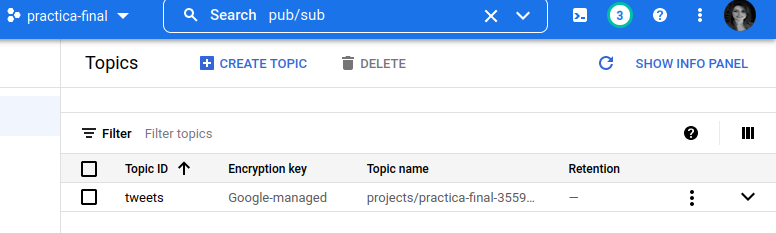

y se crea el subscriber automáticamente

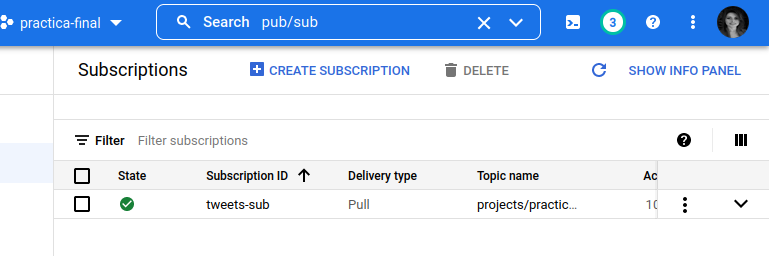

In [ ]:
# For printing gathered tweets in Colab

from main import main

class ResponseMock():

  def __init__(self, data):
    self.data = data

  def get_json(self, silent):
    return self.data

main(ResponseMock({"filter": "shakira", "debug": True}))

2022-07-10 12:49:20.448 | INFO     | main:main:77 - Creating OAuth...
2022-07-10 12:49:20.450 | INFO     | main:main:82 - Starting listener...
2022-07-10 12:49:20.451 | INFO     | main:main:84 - Debug mode: True
2022-07-10 12:49:20.454 | INFO     | main:main:90 - Recieved filter: shakira
2022-07-10 12:49:28.214 | INFO     | main:on_status:50 - .@Shakira &amp; @rihanna’s "Can’t Remember To Forget You" is now charting on @Shazam in 27 countries:

🌍 Global — #144 [RE]

🇧🇷 Brazil — #65 [+74]
🇩🇪 Germany — #101 [RE]
🇮🇹 Italy — #152 [RE]
🇹🇷 Turkiye —  #180 [RE]
🇨🇦 Canada — # 189 [RE] https://t.co/LSwkNqVDYd
2022-07-10 12:49:32.505 | INFO     | main:on_status:50 - Baforei tanto essa na época. Passava todo dia no TVZ. https://t.co/JzpuKmwO8k
2022-07-10 12:49:54.462 | INFO     | main:on_status:50 - Shakira sonho de muitas a 4 décadas sendo a maior de toda América latina
2022-07-10 12:49:58.517 | INFO     | main:on_status:50 - .@bep, @shakira, and @davidguetta's "Don't You Worry" has reached 40 M

KeyboardInterrupt: ignored

# CREAMOS NUESTRA CLOUD FUNCTION
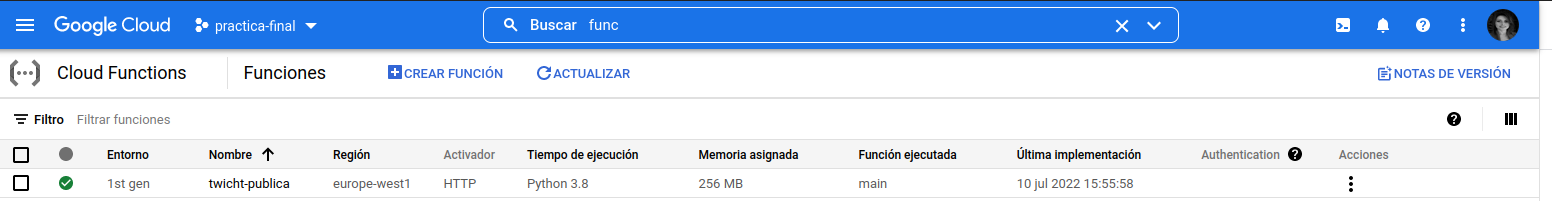

Luego de haber copiado y pegado la Main function del colab y agregar nuestros requirements nos arrojó este error en la implementación de la function

In [ ]:
# In case user service error...
! gcloud iam service-accounts add-iam-policy-binding <project_id>@appspot.gserviceaccount.com --member=user:<mail> --role=roles/iam.serviceAccountUser

/bin/bash: project_id: No such file or directory


Para lanzar vuestra Cloud Function, que recoja y mande mensajes solo tenéis que ejecutar el comando siguiente (haced los pasos vistos en clase para desplegar el servicio):

In [ ]:
! curl -X POST https://europe-west1-practica-final-355911.cloudfunctions.net/twicht-publica -H "Content-Type:application/json"  -d '{"debug": false}'


<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>403 Forbidden</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Forbidden</h1>
<h2>Your client does not have permission to get URL <code>/twicht-publica</code> from this server.</h2>
<h2></h2>
</body></html>


## Entregable 1 (3 puntos)

En este entregable desarrollarás un pipeline de inferencia en streaming usando Apache Beam para ejecutar en Dataflow un job en streaming que llamará a vuestro microservicio para realizar inferencias.

In [ ]:
%mkdir /content/streaming/subscriber

mkdir: cannot create directory ‘/content/streaming/subscriber’: File exists


In [ ]:
%cd /content/streaming/subscriber

/content/streaming/subscriber


In [ ]:
%%writefile requirements.txt

apache-beam[gcp]==2.24.0
fsspec==0.8.4
gcsfs==0.7.1
loguru==0.5.3

Overwriting requirements.txt


In [ ]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%writefile predict.py
from __future__ import absolute_import
from __future__ import print_function

import argparse
import requests
import json
import sys

import apache_beam as beam
import apache_beam.transforms.window as window
from apache_beam.options.pipeline_options import (
    GoogleCloudOptions,
    StandardOptions,
    PipelineOptions,
    SetupOptions,
)
from loguru import logger


class Predict(beam.DoFn):
    def __init__(self, predict_server) -> None:
        self.url = predict_server

    def _predict(self, text) -> str:
        payload = {"text": text}
        headers = {"accept": "application/json", "Content-Type": "application/json"}
        try:
            response = requests.post(
                self.url, data=json.dumps(payload), headers=headers
            )
            response = json.loads(response.text)
        except Exception:
            response = {"label": "undefined", "score": 0, "elapsed_time": 0}

        return response

    def process(self, element, window=beam.DoFn.WindowParam):
        logger.info(f"Text to predict: {element}")
        result = self._predict(element)
        result["text"] = element
        yield json.dumps(result)


def run(predict_server, source, sink, beam_options=None):
    with beam.Pipeline(options=beam_options) as p:
        _ = (
            p
            | "Read data from PubSub" >> source
            | "decode" >> beam.Map(lambda x: x.decode("utf-8"))
            | "window" >> beam.WindowInto(window.FixedWindows(15))
            | "Predict" >> beam.ParDo(Predict(predict_server))
            | "encode" >> beam.Map(lambda x: x.encode("utf-8")).with_output_types(bytes)
            | "Write predictions" >> sink
        )


if __name__ == "__main__":
    """Main function"""
    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )

    parser.add_argument(
        "--inputs_topic",
        dest="inputs_topic",
        required=True,
        help="Directory for temporary files and preprocessed datasets to. "
        "This can be a Google Cloud Storage path.",
    )

    parser.add_argument(
        "--outputs_topic",
        dest="outputs_topic",
        required=True,
        help="Directory for temporary files and preprocessed datasets to. "
        "This can be a Google Cloud Storage path.",
    )

    parser.add_argument(
        "--predict_server",
        dest="predict_server",
        required=True,
        help="Directory for temporary files and preprocessed datasets to. "
        "This can be a Google Cloud Storage path.",
    )

    args, pipeline_args = parser.parse_known_args()
    logger.info(args)
    beam_options = PipelineOptions(pipeline_args)
    beam_options.view_as(SetupOptions).save_main_session = True
    # beam_options.view_as(DirectOptions).direct_num_workers = 0

    project = beam_options.view_as(GoogleCloudOptions).project

    if not project:
        parser.print_usage()
        print("error: argument --project is required for streaming")
        sys.exit(1)

    beam_options.view_as(StandardOptions).streaming = True

    source = beam.io.ReadFromPubSub(
        topic="projects/{}/topics/{}".format(project, args.inputs_topic)
    ).with_output_types(bytes)

    sink = beam.io.WriteToPubSub(
        topic="projects/{}/topics/{}".format(project, args.outputs_topic)
    )

    run(args.predict_server, source, sink, beam_options)

Overwriting predict.py


In [ ]:
%%writefile setup.py

import setuptools

REQUIRED_PACKAGES = [
    "apache-beam[gcp]==2.24.0",
    "fsspec==0.8.4",
    "gcsfs==0.7.1",
    "loguru==0.5.3",
]

setuptools.setup(
    name="twitchstreaming",
    version="0.0.1",
    install_requires=REQUIRED_PACKAGES,
    packages=setuptools.find_packages(),
    include_package_data=True,
    description="Twitch Troll Detection",
)

Overwriting setup.py


### Validación inferencia en streaming

Con el comando mostrado a continuación se genera un job en streaming de Dataflow. Antes de ejecutarlo, deberás crear dos topicos en Pub/Sub, `twitch-chat` donde se recibirán los mensajes de twitch, y `twitch-chat-predictions` donde se mandarán las predicciones generadas por vuestro microservicio.

**Importante**: no te olvides de modificar la URL de tu microservicio de inferencia.

In [ ]:
GCP_WORK_DIR = 'gs://final-practice-test-execution'
GCP_REGION = 'us-east1'

# CREAMOS LOS TOPICOS 

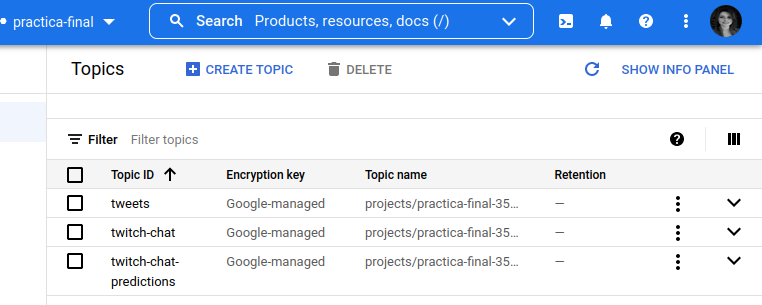

In [ ]:
! python3 predict.py \
--project $PROJECT_ID \
--region $GCP_REGION \
--runner DataflowRunner \
--temp_location $GCP_WORK_DIR/beam-temp \
--setup_file ./setup.py \
--inputs_topic twitch-chat \
--outputs_topic twitch-chat-predictions \
--predict_server https://troll-detection-service-g2v7skqfeq-uc.a.run.app/api/model/predict \

2022-07-10 10:31:33.720 | INFO     | __main__:<module>:88 - Namespace(inputs_topic='twitch-chat', outputs_topic='twitch-chat-predictions', predict_server='https://troll-detection-service-g2v7skqfeq-uc.a.run.app/api/model/predict')
usage: predict.py [-h] [--dataflow_endpoint DATAFLOW_ENDPOINT]
                  [--project PROJECT] [--job_name JOB_NAME]
                  [--staging_location STAGING_LOCATION]
                  [--temp_location TEMP_LOCATION] [--region REGION]
                  [--service_account_email SERVICE_ACCOUNT_EMAIL] [--no_auth]
                  [--template_location TEMPLATE_LOCATION] [--label LABELS]
                  [--update] [--transform_name_mapping TRANSFORM_NAME_MAPPING]
                  [--enable_streaming_engine]
                  [--dataflow_kms_key DATAFLOW_KMS_KEY]
                  [--flexrs_goal {COST_OPTIMIZED,SPEED_OPTIMIZED}]
predict.py: error: argument --project: expected one argument
